# CNN + GlobalAvgPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests RCI GMM(2).

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Rerun CNN_169 with pretty pictures.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-06 13:31:42.961084
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=20
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-06 13:31:48.606172
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        self.all_genes = [g for (g,t) in allids]
        
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self, gene_set):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        for i in range(cnt):
            gene_id,tran_id = self.all_ids[i]
            if gene_id in gene_set:
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            # Optimal discriminator = weighted average of means of the 2 gaussians
            discrim = gmm2.weights_[0]*gmm2.means_[0]+gmm2.weights_[1]*gmm2.means_[1]
            print('Model params (mean %.2f, wgt %.2f) (mean %.2f, wgt %.2f)' %
                (gmm2.means_[0], gmm2.weights_[0], gmm2.means_[1], gmm2.weights_[1]))
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(train_index)
            X_train,y_train = self.get_X_y(train_genes)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            valid_genes = self.get_gene_subset(valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            train_genes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-06 13:31:51.342694
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-06 13:32:01.285564
splitting
Fold 1
Model params (mean 0.03, wgt 0.69) (mean -2.71, wgt 0.31)
RCI threshold derived from training set: [-0.80899587]
FIT
2023-02-06 13:32:07.125175
PREDICT
2023-02-06 13:32:49.493415


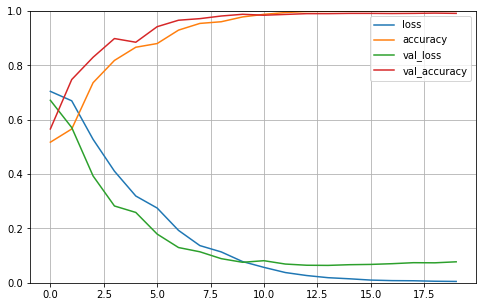

Train set ones/size 1185 / 2430
Compute valiation accuracy
Valid sizes (2062, 4997) (2062,)
Valid set ones/size 963 / 2062
Range of scores: 3.2588457e-16 to 1.0
Score threshold 0.5
Prediction set ones/size 961 / 2062


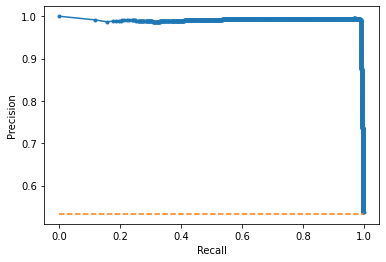

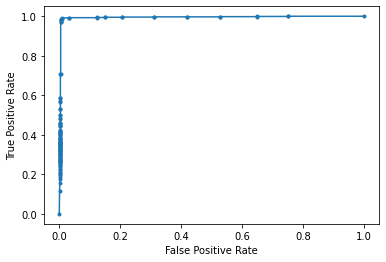

Accuracy: 99.13% Precision: 99.17% Recall: 98.96%
F1: 99.06% AUPRC: 99.02% AUROC: 99.39%
2023-02-06 13:32:50.365618
Fold 2
Model params (mean 0.04, wgt 0.69) (mean -2.71, wgt 0.31)
RCI threshold derived from training set: [-0.80553108]
FIT
2023-02-06 13:32:52.851613
PREDICT
2023-02-06 13:33:34.454299


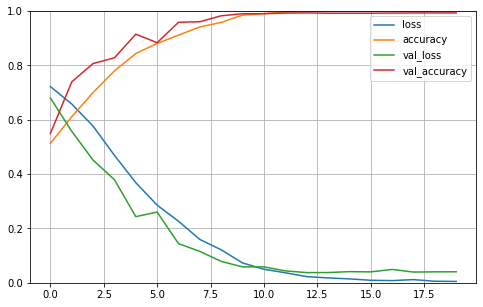

Train set ones/size 1188 / 2434
Compute valiation accuracy
Valid sizes (2101, 4997) (2101,)
Valid set ones/size 995 / 2101
Range of scores: 1.5330342e-17 to 1.0
Score threshold 0.5
Prediction set ones/size 996 / 2101


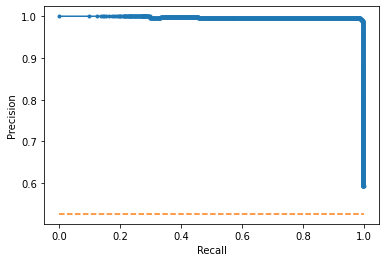

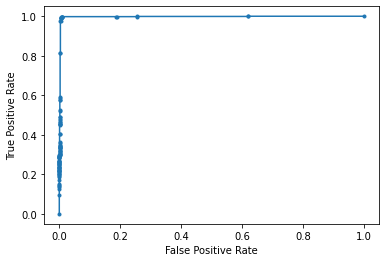

Accuracy: 99.29% Precision: 99.20% Recall: 99.30%
F1: 99.25% AUPRC: 99.66% AUROC: 99.74%
2023-02-06 13:33:35.804926
Fold 3
Model params (mean -2.71, wgt 0.31) (mean 0.03, wgt 0.69)
RCI threshold derived from training set: [-0.81395013]
FIT
2023-02-06 13:33:38.399164
PREDICT
2023-02-06 13:33:59.470541


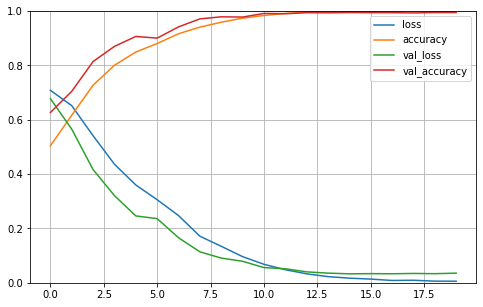

Train set ones/size 1177 / 2425
Compute valiation accuracy
Valid sizes (2104, 4997) (2104,)
Valid set ones/size 991 / 2104
Range of scores: 1.796763e-16 to 1.0
Score threshold 0.5
Prediction set ones/size 985 / 2104


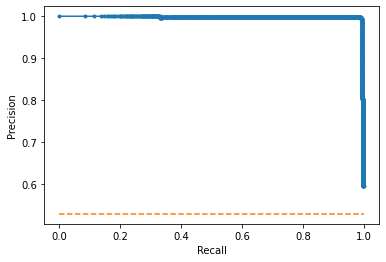

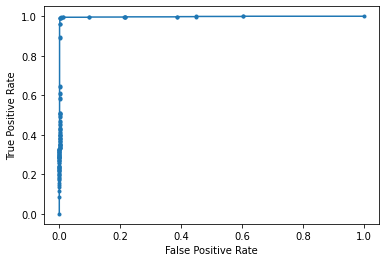

Accuracy: 99.43% Precision: 99.70% Recall: 99.09%
F1: 99.39% AUPRC: 99.75% AUROC: 99.76%
2023-02-06 13:34:00.545645
Fold 4
Model params (mean 0.05, wgt 0.69) (mean -2.70, wgt 0.31)
RCI threshold derived from training set: [-0.80197824]
FIT
2023-02-06 13:34:03.219068
PREDICT
2023-02-06 13:34:24.322951


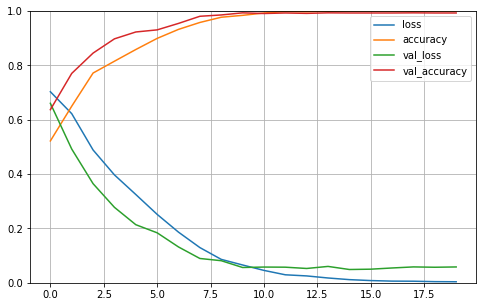

Train set ones/size 1192 / 2441
Compute valiation accuracy
Valid sizes (2060, 4997) (2060,)
Valid set ones/size 969 / 2060
Range of scores: 2.0835705e-19 to 1.0
Score threshold 0.5
Prediction set ones/size 974 / 2060


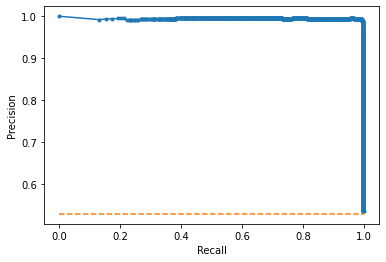

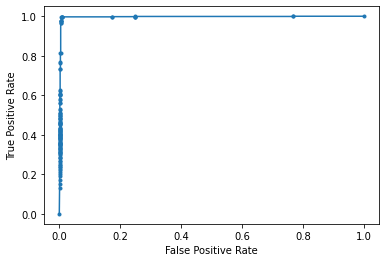

Accuracy: 99.27% Precision: 98.97% Recall: 99.48%
F1: 99.23% AUPRC: 99.38% AUROC: 99.64%
2023-02-06 13:34:25.116856
Fold 5
Model params (mean 0.03, wgt 0.70) (mean -2.71, wgt 0.30)
RCI threshold derived from training set: [-0.80420076]
FIT
2023-02-06 13:34:28.591011
PREDICT
2023-02-06 13:34:49.572804


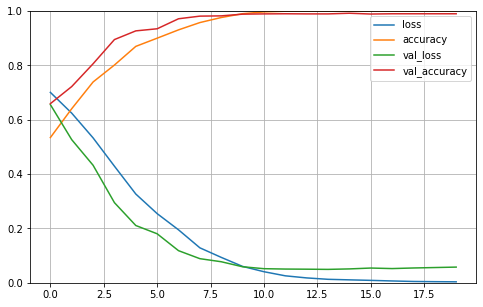

Train set ones/size 1179 / 2420
Compute valiation accuracy
Valid sizes (2065, 4997) (2065,)
Valid set ones/size 980 / 2065
Range of scores: 4.727722e-16 to 1.0
Score threshold 0.5
Prediction set ones/size 981 / 2065


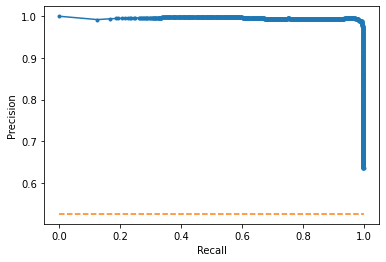

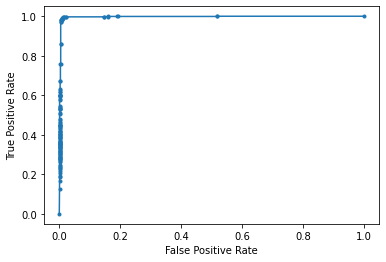

Accuracy: 98.98% Precision: 98.88% Recall: 98.98%
F1: 98.93% AUPRC: 99.49% AUROC: 99.70%
2023-02-06 13:34:50.336733

Completed cross validation 5 folds 20 epochs
 accuracy mean 99.22% +/- 0.15
 precision mean 99.18% +/- 0.28
 recall mean 99.16% +/- 0.20
 F1 mean 99.17% +/- 0.16
 AUPRC mean 99.46% +/- 0.26
 AUROC mean 99.64% +/- 0.13
Finished cell Line 14 IMR.90

2023-02-06 13:34:51.570614


In [10]:
for CELL_LINE in [14]:    # range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())